# Business Viability: Open a Sushi or Greek Restaurant? #


## Goal of this Notebook ## 
We have been approached by a food and beverage (F&B) venture capital (VC) firm to see if it would make good business senses to launch restaurant operations for either Sushi or Greek style food in Oshawa (and potentially a seed for a chain), or don’t enter either market at all.

In [89]:
# Install Folium and other requirement - after running this once you can comment out everything in this cel ###
#!pip install folium
#!pip install shapely
#!pip install geopy
#!pip install haversine

In [90]:
### Library Imports ###
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

import json
from pandas.io.json import json_normalize # tranforming json file into a pandas dataframe library
import folium # plotting library
from shapely.geometry import shape, Point

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from bs4 import BeautifulSoup
import requests
import re
import ast

In [91]:
# Four Square Credentials
CLIENT_ID = 'YSSOIRT5I5B4CSAOTZAUV4QA014DFM5K3FWGQDF0BR51QHC5' # your Foursquare ID
CLIENT_SECRET = '2JRI523PFJ4KX3Y32XU4EQUYHC5PXKX5DTTMSB535Y12VKZJ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [92]:
# Venue Query Function: Returns Greek Venues within ~8km of LAT/LONG position ###
# Durham Region area = 2,523 km^2, number of Neighborhoods = 8, so 8*100386*pi = 115 ##
def queryAPI(latitude, longitude, search_query):
    radius = 8000 # meters
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    
    results = requests.get(url).json()
    venues = results['response']['venues']
    return json_normalize(venues)

## Oshawa Durham Region Location Set Up ##

In [93]:
# If I didn't use Watson I would load the Durham Region GEO JSON data on neighborhoods this way 
with open('DurhamRegion.geojson') as f:
    js = json.load(f)

# Load in the Durham Regions GEO JSON file using Watson generated code
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
# credentials_1 = {
#     'IAM_SERVICE_ID': 'iam-ServiceId-444035dd-9588-4c4d-95f1-1b15c1845c06',
#     'IBM_API_KEY_ID': '7EvFyt0uDbtqEiEU4EjehBtRHUSBvpzHzhVedcfXS3X7',
#     'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
#     'IBM_AUTH_ENDPOINT': 'https://iam.ng.bluemix.net/oidc/token',
#     'BUCKET': 'ibmcourserapythonandml-donotdelete-pr-o1pq0erjjblno9',
#     'FILE': 'DurhamRegion.geojson'
# }


In [94]:
# This was inserted object if I was doing it on Watson Data Science Experience

# import types
# import pandas as pd
# from botocore.client import Config
# import ibm_boto3

# def __iter__(self): return 0

# # @hidden_cell
# # The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# # You might want to remove those credentials before you share your notebook.
# client_c031707209a846b49a277a00b79d3c9f = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id='7EvFyt0uDbtqEiEU4EjehBtRHUSBvpzHzhVedcfXS3X7',
#     ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
#     config=Config(signature_version='oauth'),
#     endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

# # Your data file was loaded into a botocore.response.StreamingBody object.
# # Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# # ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# # pandas documentation: http://pandas.pydata.org/
# streaming_body_1 = client_c031707209a846b49a277a00b79d3c9f.get_object(Bucket='ibmcourserapythonandml-donotdelete-pr-o1pq0erjjblno9', Key='DurhamRegion.geojson')['Body']
# # add missing __iter__ method, so pandas accepts body as file-like object
# if not hasattr(streaming_body_1, "__iter__"): streaming_body_1.__iter__ = types.MethodType( __iter__, streaming_body_1 ) 

# js = json.load(streaming_body_1)

In [95]:
# Determine what neighborhood a LAT/LONG point belongs to by using my GEO JSON file
# This is a function that will go and find the names of the neighborhood for a LAT/LONG point.
# The durham region doesn't have neighborhoods per se, but this will serve for communities
def neighborhood(x):
    p = Point(x[1],x[0])
    # check each shape to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(p):
            return feature['properties']['NAME']

# Find the center point of a neighborhood using the LAT/LONG using the GEO JSON shape we've found
def create_neighborhood_centers():
    # Updated Lists
    names = []
    longitude = []
    latitude = []
    
    # Find center points
    for feature in js['features']:
        names.append(feature['properties']['NAME'])
        points = feature['geometry']['coordinates']
        x = [p[0] for p in points[0]]
        y = [p[1] for p in points[0]]
        longitude.append(sum(x) / len(points[0]))
        latitude.append(sum(y) / len(points[0]))
    
    # Create Dataframe
    neighborhood_centers = pd.DataFrame({'Neighborhoods':names,'latitude':latitude,'longitude':longitude})
    neighborhood_centers.to_csv("centers.csv",index=False)
    
create_neighborhood_centers()

In [96]:
centers = pd.read_csv("centers.csv")
centers

Neighborhoods   latitude  longitude
0        Scugog  44.154083 -78.864576
1      Uxbridge  44.113606 -79.219505
2          Ajax  43.836971 -79.020873
3     Pickering  43.826172 -79.104141
4        Whitby  43.855884 -78.934945
5        Oshawa  43.869820 -78.838396
6    Clarington  43.920869 -78.614387
7         Brock  44.452814 -79.162786

## Get Data ##

In [97]:
##Look for all venues of Greek & Sushi in each neighborhood ... then Create & Save a csv file of it and make a data frame ###  
greek = []
sushi = []

for x in range(len(centers)):
    print("Processing %d out of 8 Neighborhoods" % x)
    print("Greek")
    # Get data from API, Assign a neighborhood, Filter columns, and add dataframe to list for Greek
    venues = queryAPI(centers.iloc[x]['latitude'],centers.iloc[x]['longitude'], 'Greek')
    venues['Neighborhood'] = centers.iloc[x]['Neighborhoods']
#     venues = venues[['name', 'Neighborhood','categories','location.address','location.lat', 'location.lng','id']]
    greek.append(venues)

    print("Sushi")
    # Get data from API, Assign a neighborhood, Filter columns, and add dataframe to list for sushi
    venues = queryAPI(centers.iloc[x]['latitude'],centers.iloc[x]['longitude'], 'Sushi')
    venues['Neighborhood'] = centers.iloc[x]['Neighborhoods']
#     venues = venues[['name', 'Neighborhood','categories','location.address','location.lat', 'location.lng','id']]
    sushi.append(venues)

print("Deleting empty results")
# Remove all neigborhoods that returned no results #
greek = [x for x in greek if len(x)>0]
sushi = [x for x in sushi if len(x)>0]

# Put together the dataframes in greek and sushi 
all_greek = greek[0]
for x in range(1,len(greek)): 
    all_greek = all_greek.append(greek[x])

all_sushi = sushi[0]
for x in range(1,len(sushi)): 
    all_sushi = all_sushi.append(sushi[x])

Processing 0 out of 8 Neighborhoods
Greek
Sushi
Processing 1 out of 8 Neighborhoods
Greek
Sushi
Processing 2 out of 8 Neighborhoods
Greek
Sushi
Processing 3 out of 8 Neighborhoods
Greek
Sushi
Processing 4 out of 8 Neighborhoods
Greek
Sushi
Processing 5 out of 8 Neighborhoods
Greek
Sushi
Processing 6 out of 8 Neighborhoods
Greek
Sushi
Processing 7 out of 8 Neighborhoods
Greek
Sushi
Deleting empty results


In [98]:
def get_rating(x):
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(x, CLIENT_ID, CLIENT_SECRET, VERSION)
 
    result = requests.get(url).json()

    try:
        return result['response']['venue']['rating']
    except:
        return -1

# Get Ratings for the Greek Restaurants in the Durham region
all_greek['Rating'] = all_greek['id'].apply(get_rating)
all_greek.to_csv('greek.csv',index=False)

# Get Ratings for the Sushi Restaurants in the Durham region
all_sushi['Rating'] = all_sushi['id'].apply(get_rating)
all_sushi.to_csv('sushi.csv',index=False)

In [99]:
# Scan in our preprocessed Greek restaurant file
greek = pd.read_csv('greek.csv')
greek['Neighborhood'] = [neighborhood((greek.iloc[x]['location.lat'],greek.iloc[x]['location.lng'])) for x in range(len(greek))]
greek = greek[['name', 'Neighborhood','categories','location.address','location.lat', 'location.lng','id', 'Rating']]
greek = greek.drop_duplicates()

# Scan in our preprocessed Sushi restaurant file
sushi = pd.read_csv('sushi.csv')
sushi['Neighborhood'] = [neighborhood((sushi.iloc[x]['location.lat'],sushi.iloc[x]['location.lng'])) for x in range(len(sushi))]
sushi = sushi[['name', 'Neighborhood','categories','location.address','location.lat', 'location.lng','id', 'Rating']]
sushi = sushi.drop_duplicates()

## Restaurants in the Durham Area ###

In [100]:
# Sometime the map loads slowly
# Note the map that gets generated is interactive so you can select Greek or Sushi and toggle them OFF or ON
# on the map.

dot_map = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)

# Add the Greek Restaurants as Green circle markers on our map of the Durham region
group0 = folium.FeatureGroup(name='<span style=\\"color: green;\\">Greek</span>')
for lat, lng, label in zip(greek['location.lat'], greek['location.lng'],greek['name']):
    folium.Circle([lat,lng], 25, color='green', fill=True).add_child(folium.Popup(label)).add_to(group0)
group0.add_to(dot_map)

# Add the Sushi Restaurants as Red circle markers on our map of the Durham region
group1 = folium.FeatureGroup(name='<span style=\\"color: red;\\">Sushi</span>')
for lat, lng, label in zip(sushi['location.lat'], sushi['location.lng'],sushi['name']):
    folium.Circle([lat,lng], 25, color='red', fill=True).add_child(folium.Popup(label)).add_to(group1)
group1.add_to(dot_map)

folium.map.LayerControl('topright', collapsed=False).add_to(dot_map)

dot_map

## Greek Restaurant Density for the Durham Area ##

In [101]:
density = greek.groupby('Neighborhood')['id'].count().reset_index()

greek_map = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=9)
durham_geo = 'DurhamRegion.geojson'
greek_map.choropleth(geo_data=durham_geo,
    data=density,
    columns=['Neighborhood','id'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Number of Greek Restaurants')

greek_map

## Sushi Restaurant Density ##

In [102]:
density = sushi.groupby('Neighborhood')['id'].count().reset_index()

sushi_map = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=9)
van_geo = "DurhamRegion.geojson"
sushi_map.choropleth(geo_data=durham_geo,
    data=density,
    columns=['Neighborhood','id'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Number of Sushi Restaurants')

sushi_map

## Sushi Restaurant Ratings ##

In [103]:
# Sometimes the API doesn't give me any ratings ... and you will see a grey box here. 
# Sometimes I have to leave things for an hour and try again.

sushi = sushi[sushi['Rating'] >= 0]
s = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=9)
d_geo = "DurhamRegion.geojson"
s.choropleth(geo_data=d_geo,
    data=sushi,
    columns=['Neighborhood','Rating'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Ratings')

s

## Greek Restaurant Ratings ##

In [114]:
# Sometimes the API doesn't give me any ratings ... and you will see a grey box here. 
# Sometimes I have to leave things for an hour and try again.

greek = greek[greek['Rating'] >= 0]
m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=9)
d_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=d_geo,
    data=greek,
    columns=['Neighborhood','Rating'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Ratings')

m

## Top 5 Business Regions to look at ## 

In [105]:
# Because this region isn't as dense, we will use a larger radius
def getNearbyVenues(names, latitudes, longitudes, radius=7650):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)

        # set the URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
           CLIENT_ID,
           CLIENT_SECRET,
           VERSION,
           lat,
           lng,
           radius,
           LIMIT)

       # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

       # return only relevant information for each nearby venue
        venues_list.append([(
           name,
           lat,
           lng,
           v['venue']['name'],
           v['venue']['location']['lat'],
           v['venue']['location']['lng'],
           v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                 'Neighborhood Latitude',
                 'Neighborhood Longitude',
                 'Venue',
                 'Venue Latitude',
                 'Venue Longitude',
                 'Venue Category']

    return(nearby_venues)

In [106]:
durham_venues = getNearbyVenues(names=centers['Neighborhoods'],
                                   latitudes=centers['latitude'],
                                   longitudes=centers['longitude']
                                  )
durham_venues.to_csv('durham_venues.csv', index=False)

Scugog
Uxbridge
Ajax
Pickering
Whitby
Oshawa
Clarington
Brock


In [107]:
durham_venues = pd.read_csv('durham_venues.csv')
temp = durham_venues.groupby(['Neighborhood','Venue Category'])['Venue'].count().reset_index().sort_values(['Neighborhood','Venue'], ascending=False)
temp = temp.groupby('Neighborhood').head(5).set_index('Neighborhood')

In [108]:
area = temp.iloc[0].name
print("--------TOP 5 Business Categories by Neighborhood--------")
print('--{}--'.format(area))
for x in range(len(temp)):
    if not area == temp.iloc[x].name:
        area = temp.iloc[x].name
        print('\n--{}--'.format(area))
    print('{}'.format(temp.iloc[x]['Venue Category']))

--------TOP 5 Business Categories by Neighborhood--------
--Whitby--
American Restaurant
Breakfast Spot
Park
Restaurant
Arcade

--Uxbridge--
Coffee Shop
Farm
Fast Food Restaurant
Golf Course
Grocery Store

--Scugog--
Food Truck
Grocery Store
Harbor / Marina
Casino
Clothing Store

--Pickering--
Beach
Fast Food Restaurant
Indian Restaurant
Mexican Restaurant
Park

--Oshawa--
Burger Joint
Coffee Shop
Restaurant
Sandwich Place
Steakhouse

--Clarington--
Coffee Shop
Pharmacy
Fast Food Restaurant
Sandwich Place
Grocery Store

--Brock--
Bank
Beer Store
Canal Lock
Sandwich Place
Supermarket

--Ajax--
Park
Coffee Shop
Gym
Afghan Restaurant
Bookstore


# This is where we set up the kmeans cluster and look at clustering of businesses (by regions/neighbourhoods) in the Durham area.


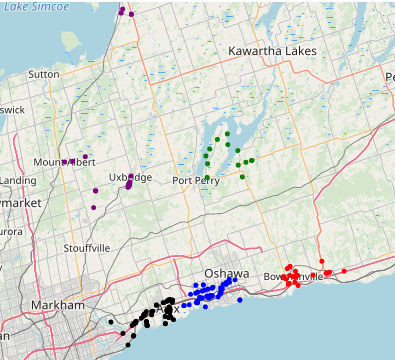

In [132]:
# These are my results with k=5 but I chose to use k=3. 
# That code is executed below and the k=5 experiment is commented out.
from IPython.display import Image
Image(filename='k5.png')

In [133]:
# I started with k=5 and played around.
# You will see below I ended up with k=3 which is the code I ran.
# This was the k=5 code where I had to adjust the colors and the k variable.
# -------------------------------------------------------------------

# Set the colors for k=5
# ----------------------
#Colors5 = ['red','blue','purple','green','black']

# Set up kmeans for k=5
# ---------------------
#means5 = KMeans(n_clusters=5, random_state=0).fit(durham_venues.iloc[:,4:6])

# This is the visualization of k=5
# --------------------------------
#durham_venues['colors5'] = kmeans5.labels_
#dot_map = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=13)
#for lat, lng, label, color in zip(durham_venues['Venue Latitude'], durham_venues['Venue Longitude'],durham_venues['Venue Category'], durham_venues['Colors']):
#   folium.Circle([lat,lng], 25, color=colors5[color], fill=True).add_child(folium.Popup(label)).add_to(dot_map)
 
#dot_map

In [134]:
# I settled on using k=3 ... so this is the code we will run

# Set the colors for k=3
# ----------------------
colors = ['red','blue','purple']

# Set up kmeans for k=3
# ---------------------
kmeans = KMeans(n_clusters=3, random_state=0).fit(durham_venues.iloc[:,4:6])

In [136]:
# I am clustering together (by regions) the businesses in the area.
# This is the visualization of k=3

durham_venues['Colors'] = kmeans.labels_

dot_map = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=8)

for lat, lng, label, color in zip(durham_venues['Venue Latitude'], durham_venues['Venue Longitude'],durham_venues['Venue Category'], durham_venues['Colors']):
    folium.Circle([lat,lng], 25, color=colors[color], fill=True).add_child(folium.Popup(label)).add_to(dot_map)
    
dot_map

In [137]:
# Let's try DBSCAN so we can try to cluster around some areas
# I did this to try and see some clusters of business and perhaps this is a good place to place a business
# is near others

# This gives us the distance between each point - that is what eps in DBSCAN
# I also played with the min samples to make something matter, how many points need to be around it to count
from scipy.spatial.distance import pdist, squareform
from haversine import haversine
distance_matrix = squareform(pdist(durham_venues.iloc[:,4:6], (lambda u,v: haversine(u,v))))
db = DBSCAN(eps=.225, min_samples=3, metric="precomputed")
y_db = db.fit_predict(distance_matrix)

In [138]:
y_db

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,  0, -1,  0,
       -1, -1, -1,  1, -1,  2, -1, -1, -1,  2, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1, -1, -1,  4,
        3, -1,  4,  5,  3, -1, -1, -1,  4, -1, -1,  5,  3,  4, -1, -1, -1,
       -1, -1,  4, -1,  5, -1, -1, -1, -1,  4,  6,  6, -1,  6, -1, -1,  7,
       -1, -1, -1, -1, -1, -1, -1,  8,  8, -1,  6,  8, -1,  8,  7, -1, -1,
       -1, -1, -1,  8, -1, -1, -1, -1, -1,  9,  9,  9, -1, 10, 10, -1, -1,
       -1, -1,  9, -1, -1, -1,  9,  7, -1, 10,  9, -1, -1, -1, -1,  9, -1,
       -1,  7, -1, -1, -1, 11, 12, -1, 13, -1, 11, -1, -1, -1, 11, 11, -1,
       -1, 12, -1, 14, -1, 14, 11, -1, 13, 13, 12, -1, 14, -1, 13, -1, -1,
       -1, -1, -1])

In [142]:
colors = ['red','blue','purple','green','black','yellow', 'brown','white','cyan']
durham_venues['Colors'] = y_db

dot_map = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=11)

for lat, lng, label, color in zip(durham_venues['Venue Latitude'], durham_venues['Venue Longitude'],durham_venues['Venue Category'], durham_venues['Colors']):
    if color < 0: 
        folium.Circle([lat,lng], 25, color='gray', fill=True).add_child(folium.Popup(label)).add_to(dot_map)
    else:
        folium.Circle([lat,lng], 25, color=colors[int((color-1)/4)], fill=True).add_child(folium.Popup(label)).add_to(dot_map)
    
dot_map

## Rental Properties from https://www.spacelist.ca/listings/on/oshawa ##

In [175]:
def get_commercial_rent():
    # Set up the link, get the html from the page, and put the contents into beautiful soup
    page_link = 'https://www.spacelist.ca/listings/on/oshawa'
    page_response = requests.get(page_link, timeout=5)
    page_content = BeautifulSoup(page_response.content, "html.parser")

    # Seperate out the listngs to get id and rent
    listings = page_content.find_all('a', {'class':'listing-card'})

    # Get the location data out of the html and turn it into a dictionary
    locations = ast.literal_eval(re.findall("data-data='{\"type\":\"FeatureCollection\",\"features\":\[(.*)\]\}'", str(page_content.find('div', id='cluster-map')))[0])

    # Set a list to store values to and grab the id, latitude, and longitude
    location_list = []
    for i,x in enumerate(locations):
        location_id = locations[i]['properties']['id']
        longitude = locations[i]['geometry']['coordinates'][0]
        latitude = locations[i]['geometry']['coordinates'][1]
        location_list.append([location_id, latitude, longitude])

    # Convert location_list into a pandas dataframe and export to a csv
    l = pd.DataFrame(location_list, columns=['id', 'lat', 'lon'])
    l.to_csv('locations.csv', index=False)

    # Collect A Single Page of rent data that we got from the above url and add it to a list called rent 
    rent = []
    for listing in listings:
        listing_id = re.findall('data-listing=\"(.*\d)\" ',str(listing))[0]
        try:
            listing_price = listing.find('div', {'class':'rent_per_month'}).text
        except:
            listing_price = None

        rent.append([listing_id, listing_price])

    # Collect all the pages of Data from page 2 - 47, then extract the rent and id and place it on a list called rent
    for x in range(2,4):
        page_link = 'https://www.spacelist.ca/listings/on/oshawa/page/{}'.format(x)
        page_response = requests.get(page_link, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        listings = page_content.find_all('a', {'class':'listing-card'})

        for listing in listings:
            listing_id = re.findall('data-listing=\"(.*\d)\" ',str(listing))[0]
            try:
                listing_price = listing.find('div', {'class':'rent_per_month'}).text
            except:
                listing_price = None

            rent.append([listing_id, listing_price])

    # Convert rent into a pandas dataframe and export to a csv
    r = pd.DataFrame(rent, columns=['id', 'rent'])
    r.to_csv('rent.csv',index=False)
    
get_commercial_rent()

In [176]:
locations = pd.read_csv('locations.csv') 
rent = pd.read_csv('rent.csv') 
locations['neighborhood'] = [neighborhood((locations.iloc[x]['lat'],locations.iloc[x]['lon'])) for x in range(len(locations))]
rentals = pd.merge(rent, locations, on=['id','id'])

In [177]:
def to_numeric(x):
        x = x.replace('$','')
        x = x.replace('/mo','')
        x = x.replace(',','')
        
        if x == 'Contact' or x == 'None':
            return None
        
        if '-' in x: 
            values = x.split('-')
            return (float(values[1]) + float(values[0]))/2
        else:
            return float(x)

rentals['rent'] = rentals['rent'].astype(str).apply(to_numeric)

## Number of Available Rental Properties in Oshawa ##

In [178]:
density = rentals.groupby('neighborhood')['id'].count().reset_index()

m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)
durham_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=van_geo,
    data=density,
    columns=['neighborhood','id'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Properties for Rent')

m

In [179]:
density

neighborhood  id
0   Clarington   1
1       Oshawa  43

## Monthly Rental Price in Oshawa ##

In [181]:
density = rentals[rentals['rent']<100000].groupby('neighborhood')['rent'].median().reset_index()
 
m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)
durham_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=van_geo,
    data=density,
    columns=['neighborhood','rent'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Rental Price')

m

## Rental Properties from https://www.spacelist.ca/listings/on/whitby ##

In [182]:
def get_commercial_rent():
    # Set up the link, get the html from the page, and put the contents into beautiful soup
    page_link = 'https://www.spacelist.ca/listings/on/whitby'
    page_response = requests.get(page_link, timeout=5)
    page_content = BeautifulSoup(page_response.content, "html.parser")

    # Seperate out the listngs to get id and rent
    listings = page_content.find_all('a', {'class':'listing-card'})

    # Get the location data out of the html and turn it into a dictionary
    locations = ast.literal_eval(re.findall("data-data='{\"type\":\"FeatureCollection\",\"features\":\[(.*)\]\}'", str(page_content.find('div', id='cluster-map')))[0])

    # Set a list to store values to and grab the id, latitude, and longitude
    location_list = []
    for i,x in enumerate(locations):
        location_id = locations[i]['properties']['id']
        longitude = locations[i]['geometry']['coordinates'][0]
        latitude = locations[i]['geometry']['coordinates'][1]
        location_list.append([location_id, latitude, longitude])

    # Convert location_list into a pandas dataframe and export to a csv
    l = pd.DataFrame(location_list, columns=['id', 'lat', 'lon'])
    l.to_csv('locations.csv', index=False)

    # Collect A Single Page of rent data that we got from the above url and add it to a list called rent 
    rent = []
    for listing in listings:
        listing_id = re.findall('data-listing=\"(.*\d)\" ',str(listing))[0]
        try:
            listing_price = listing.find('div', {'class':'rent_per_month'}).text
        except:
            listing_price = None

        rent.append([listing_id, listing_price])

    # Collect all the pages of Data from page 2 - 47, then extract the rent and id and place it on a list called rent
    for x in range(2,4):
        page_link = 'https://www.spacelist.ca/listings/on/oshawa/page/{}'.format(x)
        page_response = requests.get(page_link, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        listings = page_content.find_all('a', {'class':'listing-card'})

        for listing in listings:
            listing_id = re.findall('data-listing=\"(.*\d)\" ',str(listing))[0]
            try:
                listing_price = listing.find('div', {'class':'rent_per_month'}).text
            except:
                listing_price = None

            rent.append([listing_id, listing_price])

    # Convert rent into a pandas dataframe and export to a csv
    r = pd.DataFrame(rent, columns=['id', 'rent'])
    r.to_csv('rent.csv',index=False)
    
get_commercial_rent()

In [183]:
locations = pd.read_csv('locations.csv') 
rent = pd.read_csv('rent.csv') 
locations['neighborhood'] = [neighborhood((locations.iloc[x]['lat'],locations.iloc[x]['lon'])) for x in range(len(locations))]
rentals = pd.merge(rent, locations, on=['id','id'])

In [184]:
def to_numeric(x):
        x = x.replace('$','')
        x = x.replace('/mo','')
        x = x.replace(',','')
        
        if x == 'Contact' or x == 'None':
            return None
        
        if '-' in x: 
            values = x.split('-')
            return (float(values[1]) + float(values[0]))/2
        else:
            return float(x)

rentals['rent'] = rentals['rent'].astype(str).apply(to_numeric)

## Number of Available Rental Properties in Whitby ##

In [185]:
density = rentals.groupby('neighborhood')['id'].count().reset_index()

m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)
durham_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=van_geo,
    data=density,
    columns=['neighborhood','id'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Properties for Rent')

m

In [186]:
density

neighborhood  id
0       Whitby  20

## Median Rental Price in Whitby ##

In [187]:
density = rentals[rentals['rent']<100000].groupby('neighborhood')['rent'].median().reset_index()
 
m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)
durham_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=van_geo,
    data=density,
    columns=['neighborhood','rent'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Rental Price')

m

## Rental Properties from https://www.spacelist.ca/listings/on/ajax ##

In [152]:
def get_commercial_rent():
    # Set up the link, get the html from the page, and put the contents into beautiful soup
    page_link = 'https://www.spacelist.ca/listings/on/ajax'
    page_response = requests.get(page_link, timeout=5)
    page_content = BeautifulSoup(page_response.content, "html.parser")

    # Seperate out the listngs to get id and rent
    listings = page_content.find_all('a', {'class':'listing-card'})

    # Get the location data out of the html and turn it into a dictionary
    locations = ast.literal_eval(re.findall("data-data='{\"type\":\"FeatureCollection\",\"features\":\[(.*)\]\}'", str(page_content.find('div', id='cluster-map')))[0])

    # Set a list to store values to and grab the id, latitude, and longitude
    location_list = []
    for i,x in enumerate(locations):
        location_id = locations[i]['properties']['id']
        longitude = locations[i]['geometry']['coordinates'][0]
        latitude = locations[i]['geometry']['coordinates'][1]
        location_list.append([location_id, latitude, longitude])

    # Convert location_list into a pandas dataframe and export to a csv
    l = pd.DataFrame(location_list, columns=['id', 'lat', 'lon'])
    l.to_csv('locations.csv', index=False)

    # Collect A Single Page of rent data that we got from the above url and add it to a list called rent 
    rent = []
    for listing in listings:
        listing_id = re.findall('data-listing=\"(.*\d)\" ',str(listing))[0]
        try:
            listing_price = listing.find('div', {'class':'rent_per_month'}).text
        except:
            listing_price = None

        rent.append([listing_id, listing_price])

    # Collect all the pages of Data from page 2 - 47, then extract the rent and id and place it on a list called rent
    for x in range(2,4):
        page_link = 'https://www.spacelist.ca/listings/on/oshawa/page/{}'.format(x)
        page_response = requests.get(page_link, timeout=5)
        page_content = BeautifulSoup(page_response.content, "html.parser")
        listings = page_content.find_all('a', {'class':'listing-card'})

        for listing in listings:
            listing_id = re.findall('data-listing=\"(.*\d)\" ',str(listing))[0]
            try:
                listing_price = listing.find('div', {'class':'rent_per_month'}).text
            except:
                listing_price = None

            rent.append([listing_id, listing_price])

    # Convert rent into a pandas dataframe and export to a csv
    r = pd.DataFrame(rent, columns=['id', 'rent'])
    r.to_csv('rent.csv',index=False)
    
get_commercial_rent()

In [153]:
locations = pd.read_csv('locations.csv') 
rent = pd.read_csv('rent.csv') 
locations['neighborhood'] = [neighborhood((locations.iloc[x]['lat'],locations.iloc[x]['lon'])) for x in range(len(locations))]
rentals = pd.merge(rent, locations, on=['id','id'])

In [154]:
def to_numeric(x):
        x = x.replace('$','')
        x = x.replace('/mo','')
        x = x.replace(',','')
        
        if x == 'Contact' or x == 'None':
            return None
        
        if '-' in x: 
            values = x.split('-')
            return (float(values[1]) + float(values[0]))/2
        else:
            return float(x)

rentals['rent'] = rentals['rent'].astype(str).apply(to_numeric)

## Number of Available Rental Properties in Ajax ##

In [169]:
density = rentals.groupby('neighborhood')['id'].count().reset_index()

m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)
durham_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=van_geo,
    data=density,
    columns=['neighborhood','id'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Properties for Rent')

m

In [159]:
density

neighborhood  id
0         Ajax  16

## Median Rental Price in Ajax ##

In [174]:
density = rentals[rentals['rent']<100000].groupby('neighborhood')['rent'].median().reset_index()
 
m = folium.Map(location = [43.8698204990823,-78.8383962533614], zoom_start=10)
durham_geo = "DurhamRegion.geojson"
m.choropleth(geo_data=van_geo,
    data=density,
    columns=['neighborhood','rent'],
    key_on='feature.properties.NAME',
    fill_color='YlOrRd',
    fill_opacity=0.5, 
    line_opacity=0.9,
    legend_name='Rental Price')

m

In [170]:
density

neighborhood  id
0         Ajax  16